In [1]:
#Submitted version
import math
import numpy as np
import scipy.linalg as la
import scipy.integrate as integrate
import scipy.special as special
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties


# Functions

In [2]:
#Matrix valued prox of G, defined below 

def ProxNuclearLogDet(gamma,mu,x):
    u, V = la.eig(x)
    u = np.real_if_close(u)
    #print (np.isreal(u))
    v =0.5 * (u- gamma*mu+ np.sqrt( (u- gamma * mu)**2 + 4*gamma ) )
    return np.dot(V,np.dot(np.diag(v), V.T))

def ProxLogDet(gamma,x):
    u, V = la.eig(x)
    u = np.real_if_close(u)
    #print (u)
    v =0.5 * (u+ np.sqrt( (u)**2 + 4*gamma ) )
    return np.dot(V,np.dot(np.diag(v), V.T))

def ProxG(gamma,nu,x):
    d = len(x)
    return ProxNuclearLogDet(gamma * (nu -d -1)/2,1/(nu -d -1),x)

#Case of 1x1 matrices
def ProxNuclearLogDet_1(gamma,mu,x):
    u = np.copy(x)
    v =0.5 * (u- gamma*mu+ math.sqrt( (u- gamma * mu)**2 + 4*gamma ) )
    return v

def ProxG_1(gamma,nu,x):
    return ProxNuclearLogDet_1(gamma * (nu -2)/2,1/(nu -2),x)

#Gradient of f_i(x) = 0.5 (D^T x D -log det(x)), x symmetric matrix
def Nablafi(x,D):
    y = la.inv(x)
    return -0.25 * (y + y.T) + 0.5 * np.dot (D, D.T)

#Gradient of f_i(x) = 0.5 (D^T x D)
def Nablafi0(x,D):
    return 0.5 * np.dot (D, D.T)

#Gradient of f_0(x) = 0.5 tr(A x), x sym
def Nablaf0(x,A):
    return 0.25 * (A + A.T)


#One dimensional similation: Gaussian likelihood
def Nablaf_1(x,D):
    return x - D

def density_1(x,D,nu):
    d = 1
    n = D.shape[0]
    dens = 0.0
    if x > 0:
        L = [(float(D[i,:]) - x) ** 2 for i in range(n)]
        F = 0.5 * sum(L)
        G = -(nu-d-1)/2 * np.log(x) + x/2
        dens = np.exp(-F-G)
    return dens


def Gamma(x,d=1):
    return np.exp(special.multigammaln(x, d))

def density(x,D,nu):
    n = D.shape[0]
    d = D.shape[1]
    Vinv = np.eye(d)+ np.dot(D.T,D)
    dens = 0.0
    if d == 1:
        if x > 0:
            theta = float(2.0*la.inv(Vinv))
            r = (nu-d+1)/2 
            dens = float(x)**(r-1) * np.exp(-float(x)/theta)
            dens = dens / (Gamma(r) * (theta ** r))
    else:
        if np.all(x-x.T==0) and np.all(np.linalg.eigvals(x) > 0):
            a = np.linalg.det(x) ** (0.5 * (nu-d-1))
            b = np.exp(-0.5 * np.trace(np.dot(Vinv,x))) #* np.linalg.det(Vinv) ** (nu/2)
            #c = (2 ** (nu * d / 2)) * Gamma(nu / 2, d)
            dens =  a*b #/ c                        
    return dens


def F(x):
    return 0.5 * float(np.dot(D.T,D))*x 

def G(x):
    alpha = - (nu-1-1)/2
    return alpha * np.log(x) + 0.5*x - 0.5 * n * np.log(x) #The last term comes from the density of multivariate gaussian (normalization term)

# One dimensional problem

$$f_i(x) = \frac{|x-D_i|^2}{2},$$
$$G(x) = -\frac{\nu-d-1}{2} \log |\det(x)| + \frac{tr(x)}{2} + \iota_{R^{d\times d}_{++}}(x)$$


In [3]:
#Setup ALGO 1D

d = 1 #Dimension
n = 10 #Nb of data points
nu = d+4 #nu parameter of the density
niter = 100000 #nb of iterations
gamma = 1.0 #step size of the algorithms

D = np.random.randn(n,d) ##Concatenation of the data points
x = 0.0 #Initialization
indices = [np.random.randint(n) for i in range(niter)]
len(indices)

100000

0.0012414188596807428


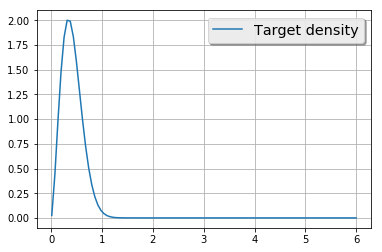

In [4]:
#Target density

xaxis = np.linspace(0.01, 6, 100)
K = integrate.quad(lambda x: density_1(x,D,nu), 0, np.inf)[0]        
print(K)
yaxis = [density_1(x,D,nu)/K for x in xaxis]


%matplotlib inline
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42


true = plt.plot(xaxis, yaxis, label = 'Target density')
legend = plt.legend(loc = 1, shadow = True, fontsize = 'x-large')

plt.grid()

plt.show()

In [5]:
#PSGLA

PSGLA = np.zeros((niter,d))  #Concatenation of the iterates of PSGLA
xp = np.copy(x) #Iterate of PSGLA
PSGLA[0,:] = xp

for i in range(niter):
    j = indices[i] #Index of randomly selected data point
    #PSGLA
    xp = xp - gamma * Nablaf_1(xp,D[j,:]) + math.sqrt(2 * gamma) * np.random.randn(d) #Gradient step of PSGLA
    xp = ProxG_1(gamma,nu,xp) #Prox step of PSGLA
    PSGLA[i,:] = xp

In [6]:
#MYULA(lamb)

MYULA = np.zeros((niter,d)) #Concatenation of the iterates of MYULA
xm = np.copy(x) #Iterate of MYULA
MYULA[0,:] = xm

lamb = 1.0 #Smoothing parameter of MYULA

for i in range(niter):
    j = indices[i] #Index of randomly selected data point
    #MYULA 
    grad = Nablaf_1(xm,D[j,:]) #Gradient of MYULA
    prox = ProxG_1(lamb,nu,xm) #Prox of MYULA
    xm = xm -gamma * (grad + (xm - prox)/lamb) + math.sqrt(2 * gamma) * np.random.randn(d) #MYULA update
    MYULA[i,:] = xm

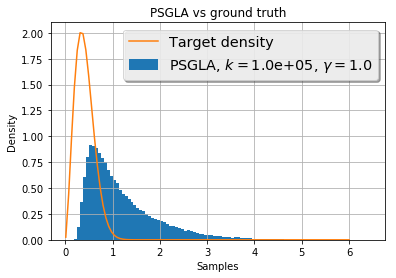

In [7]:
#Histogram PSGLA

%matplotlib inline

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42


b = int(niter/1000)
k = "{:.1e}".format(niter)
psgla = plt.hist(PSGLA, bins=b, normed=1, 
label = 'PSGLA, $k =$'+k+', $\gamma =$'+str(gamma))
true = plt.plot(xaxis, yaxis, label = 'Target density')
legend = plt.legend(loc = 1, shadow = True, fontsize = 'x-large')
plt.title('PSGLA vs ground truth')
plt.ylabel('Density')
plt.xlabel('Samples')
plt.grid()
#plt.savefig('PSGLA_k_'+str(niter)+'_gamma_'+str(gamma)+'.png')

plt.show()

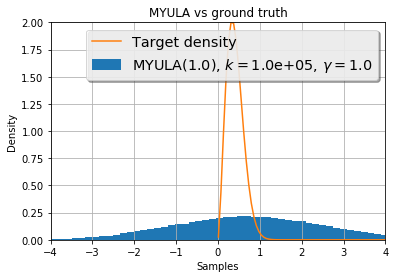

In [8]:
#Histogram MYULA(lamb)

%matplotlib inline

myula = plt.hist(MYULA, bins=b, normed=True,
label = 'MYULA('+str(lamb)+'), $k =$'+k+', $\gamma =$'+str(gamma))
true = plt.plot(xaxis, yaxis, label = 'Target density')
legend = plt.legend(loc = 1, shadow = True, fontsize = 'x-large')
plt.title('MYULA vs ground truth')
plt.ylabel('Density')
plt.xlabel('Samples')
plt.grid()
plt.axis([-4.0, 4.0, 0.0, 2.0])

#plt.savefig('MYULA_k_'+str(niter)+'_gamma_'+str(gamma)+'_lambda_'+str(lamb)+'.png')
plt.show()

# High dimensional problem

$$G(x) = -\frac{\nu+n-d-1}{2} \log |\det(x)| + \frac{tr(x)}{2} + \iota_{R^{d\times d}_{++}}(x)$$
$$F = \sum_i f_i, \quad f_i(x) = \frac{tr(D_i D_i^T x)}{2} $$
Ground truth:
Wishart with parameters $\nu' = n + \nu$ and $V' = \left(I + \sum_{i=1}^n D_i D_i^T \right)^{-1}$.
Mean a posteriori: $\nu' V'$


In [9]:
#Setup

d = 10 #Dimension
n = 10 #Nb of data points
nu = d+4 #nu parameter of the density
niter = 100 #nb of iterations
gamma = 0.01 #step size of the algorithms
V = np.eye(d) #V parameter of the Wishart prior
Vinv = la.inv(V)
D = 1.0*np.random.randn(n,d) ##Concatenation of the n data points #np.zeros((n,d)) #
nu1 = n + nu
V1 = la.inv(Vinv + np.dot(D.T,D))
aposterorimean = nu1 * V1

x = 1*np.eye(d) #Initialization
indices = [np.random.randint(n) for i in range(niter)]

In [10]:
#PSGLA

PSGLA = np.zeros((niter,d,d))  #Concatenation of the niter iterates (d x d matrices) of PSGLA
xp = np.copy(x) #Iterate of PSGLA
PSGLA[0,:] = xp
for i in range(niter):
    #Gaussian rv over the space of symmetric matrices
    A = np.random.randn(d,d)
    Gauss = (A + A.T)/2
    #PSGLA
    grad = 0.5 * np.dot(D.T,D) 
    xp = xp - gamma * grad + math.sqrt(2 * gamma) * Gauss #Gradient step of PSGLA
    xp = ProxG(gamma,nu+n,xp) #prox step
    PSGLA[i,:] = xp

In [11]:
#MYULAs

lamblist = [0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
#lamblist = [0.05, 0.1, 0.5, 1.0] #Take this list if numerical instability
#Smoothing parameter of MYULA
#small lambda ----> numerical instability/ DO NOT TAKE lambda < 1
#MYULA needs roughly gamma < lambda


MYULA = np.zeros((len(lamblist),niter,d,d)) #Concatenation of the iterates of MYULA

 
for l in range(len(lamblist)):
    xm = np.copy(x) #Iterate of MYULA
    MYULA[l,0,:] = xm
    lamb = lamblist[l]
    for i in range(niter):
        A = np.random.randn(d,d)
        Gauss = (A + A.T)/2
        #MYULA 
        grad = 0.5 * np.dot(D.T,D) #Gradient of MYULA
        prox = ProxG(lamb,nu+n,xm) #prox
        xm = xm -gamma * (grad + (xm - prox)/lamb) + math.sqrt(2 * gamma) * Gauss #MYULA update
        MYULA[l,i,:] = xm

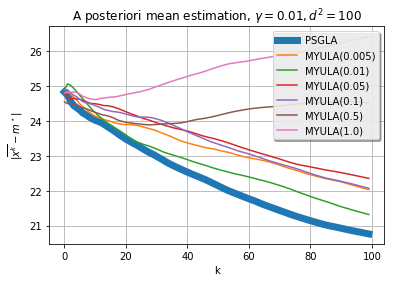

In [13]:
#Curves a posteriori mean estimation

%matplotlib inline
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42


mpsgla = np.cumsum(PSGLA,axis=0).T
mpsgla = mpsgla/np.arange(1,niter+1)
mpsgla = mpsgla.T #ergodic mean of PSGLA

mmyula = [mpsgla] * len(lamblist)
for l in range(len(lamblist)):
    mmyula[l] = np.cumsum(MYULA[l,:],axis=0).T
    mmyula[l] = mmyula[l]/np.arange(1,niter+1)
    mmyula[l] = mmyula[l].T #ergodic mean of MYULA

%matplotlib inline
ergpsgla = [la.norm(mpsgla[i,:] - aposterorimean) for i in range(niter)] #distance between ergodic average and ground truth
psgla = plt.plot(np.arange(niter), ergpsgla, label = 'PSGLA', linewidth = 7.0)

for l in range(len(lamblist)):
    lamb = lamblist[l]
    ergmyula = [la.norm(mmyula[l][i,:] - aposterorimean) for i in range(niter)] #distance between ergodic average and ground truth
    plt.plot(np.arange(niter), ergmyula, label = 'MYULA(' + str(lamb) + ')' )

fontP = FontProperties()
fontP.set_size('medium')
legend = plt.legend(loc = 1, shadow = True, fontsize = 'x-large', prop = fontP)
plt.title('A posteriori mean estimation, $\gamma =$'+str(gamma)+ '$, d^2 =$'+str(d ** 2))
plt.ylabel('$|\overline{x^k} - m^\star|$')
plt.xlabel('k')
plt.grid()
#plt.savefig('aposteriori_mean_k_'+str(niter)+'_gamma_'+str(gamma)+'_d_'+str(d)+'.png')

plt.show()